# Predicting Resolver Response Code Based on Query Headers and Zone Information

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.preprocessing, sklearn.model_selection, sklearn.tree
import graphviz 
import matplotlib.pyplot as plt

In [137]:
ALGO_NAME = {
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}
# defining priority (from low to high)
priority = [ALGO_NAME[key] for key in sorted(ALGO_NAME.keys())]

## Prepare Data

In [3]:
data = {
    name: pd.read_pickle(f'ml_data_{name}.pickle')
    for name in ALGO_NAME.values()
}

In [4]:
features = list(filter(lambda c: c.startswith('feature_dns'), next(iter(data.values())).keys()))
labels = list(filter(lambda c: c.startswith('labels_'), next(iter(data.values())).keys()))
label = 'label_rcode0andad1'

### Display all Features that have *any* Variability

In [5]:
features = list(filter(lambda f: f != 'feature_ip_src', features))

In [6]:
for algo, d in data.items():
    print(f'++++{algo}++++', len(d), 'total queries')
    for c in features + labels:
        u = np.unique(d[c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++rsasha1++++ 121 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++rsasha1nsec3sha1++++ 96 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++rsasha256++++ 116 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++rsasha512++++ 115 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++ecdsap256sha256++++ 31 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_e

### Encode String-Based Features

In [7]:
for d in data.values():
    le_feature_ip_src = sk.preprocessing.LabelEncoder()
    le_feature_ip_src.fit(d['feature_ip_src'])
    d['feature_ip_src'] = le_feature_ip_src.transform(d['feature_ip_src'])

## Train and Evaluate Decision Tree

In [8]:
tree = {}

for algo, d in data.items():
    X = d[features]
    Y = d[label]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)

    tree[algo] = sk.tree.DecisionTreeClassifier()
    tree[algo] = tree[algo].fit(X_train, Y_train)

### Evaluate Prediction Error

In [144]:
metrics = []

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X = d[features]
        Y = d[label]
        X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=4)
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test) / len(Y_test)
        metrics.append({
            'algo': algo,
            'true negative': cm[0,0],
            'true positive': cm[1,1],
            'false negative': cm[0,1],
            'false positive': cm[1,0],
            'seed': seed,
        })
        
metrics = pd.DataFrame(metrics)
metrics = metrics.groupby(['algo']).mean().sort_values('algo', key=lambda r: list(map(lambda e: priority.index(e), r)))
del metrics['seed']
print(metrics.to_latex(
    float_format=lambda f: f"{f:.0%}",
))
metrics

\begin{tabular}{lrrrr}
\toprule
{} &  true negative &  true positive &  false negative &  false positive \\
algo             &                &                &                 &                 \\
\midrule
rsasha1          &            51\% &            10\% &             31\% &              8\% \\
rsasha1nsec3sha1 &             4\% &            90\% &              6\% &              0\% \\
rsasha256        &             9\% &            88\% &              3\% &              0\% \\
rsasha512        &             0\% &            91\% &              0\% &              9\% \\
ecdsap256sha256  &            19\% &            56\% &             25\% &              0\% \\
ecdsap384sha384  &            13\% &            73\% &             13\% &              0\% \\
ed25519          &            38\% &            44\% &             12\% &              6\% \\
ed448            &            71\% &            18\% &              0\% &             12\% \\
\bottomrule
\end{tabular}



,true negative,true positive,false negative,false positive
algo,,,,
rsasha1,0.508197,0.098361,0.311475,0.081967
rsasha1nsec3sha1,0.041667,0.895833,0.062500,0.000000
rsasha256,0.086207,0.879310,0.034483,0.000000
rsasha512,0.000000,0.913793,0.000000,0.086207
ecdsap256sha256,0.187500,0.562500,0.250000,0.000000
ecdsap384sha384,0.133333,0.733333,0.133333,0.000000
ed25519,0.375000,0.437500,0.125000,0.062500
ed448,0.705882,0.176471,0.000000,0.117647


In [9]:
correct = {}

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X = d[features]
        Y = d[label]
        X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=4)

        #sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
        c = np.sum(np.diagonal(cm))/len(Y_test)
        title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
        correct.setdefault(algo, [c]).append(c)
        #plt.title(title)
        #print(title)
        
{
    algo: np.round(np.mean(cs), 3) for algo, cs in correct.items()
}

{'rsasha1': 0.607,
 'rsasha1nsec3sha1': 0.938,
 'rsasha256': 0.966,
 'rsasha512': 0.914,
 'ecdsap256sha256': 0.75,
 'ecdsap384sha384': 0.867,
 'ed25519': 0.812,
 'ed448': 0.882}

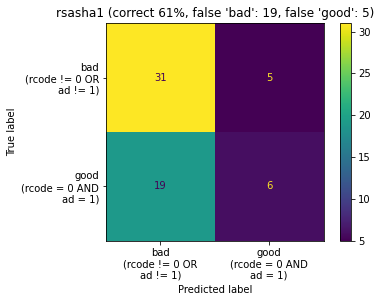

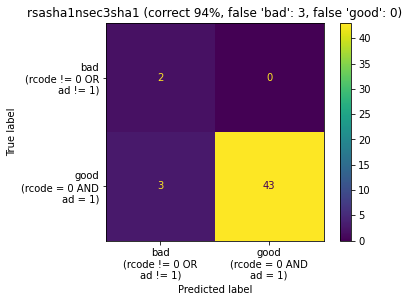

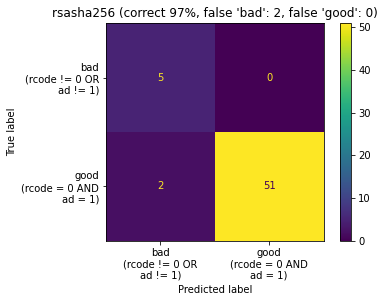

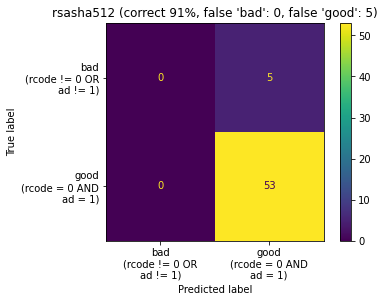

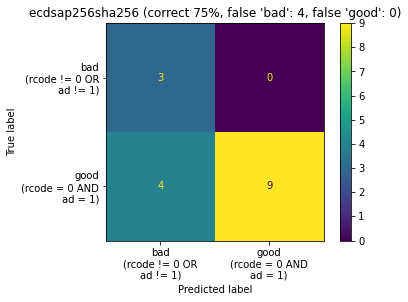

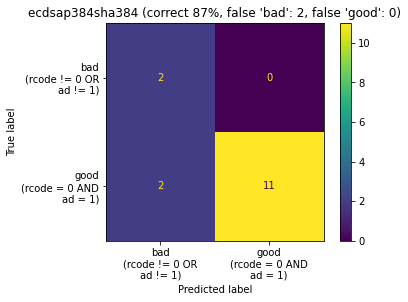

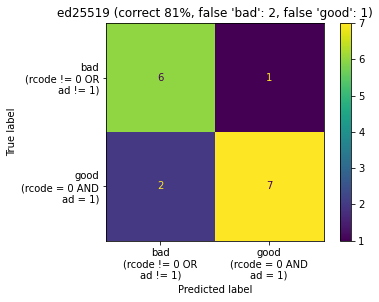

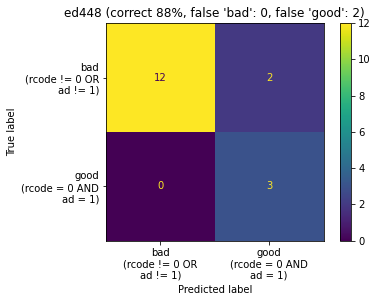

In [10]:
for algo, t in tree.items():
    d = data[algo]
    X = d[features]
    Y = d[label]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=4)

    sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
    cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
    c = np.sum(np.diagonal(cm))/len(Y_test)
    title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
    plt.title(title)


## Show Decision Tree

In [11]:
graphs = {}

for algo, t in tree.items():
    dot_data = sk.tree.export_graphviz(
        t, out_file=None, 
        feature_names=features,  
        class_names=['OK', 'Failure'],  
        filled=True, rounded=True,  
        special_characters=True,
        impurity=True,
    )  
    graphs[algo] = graphviz.Source(dot_data)  

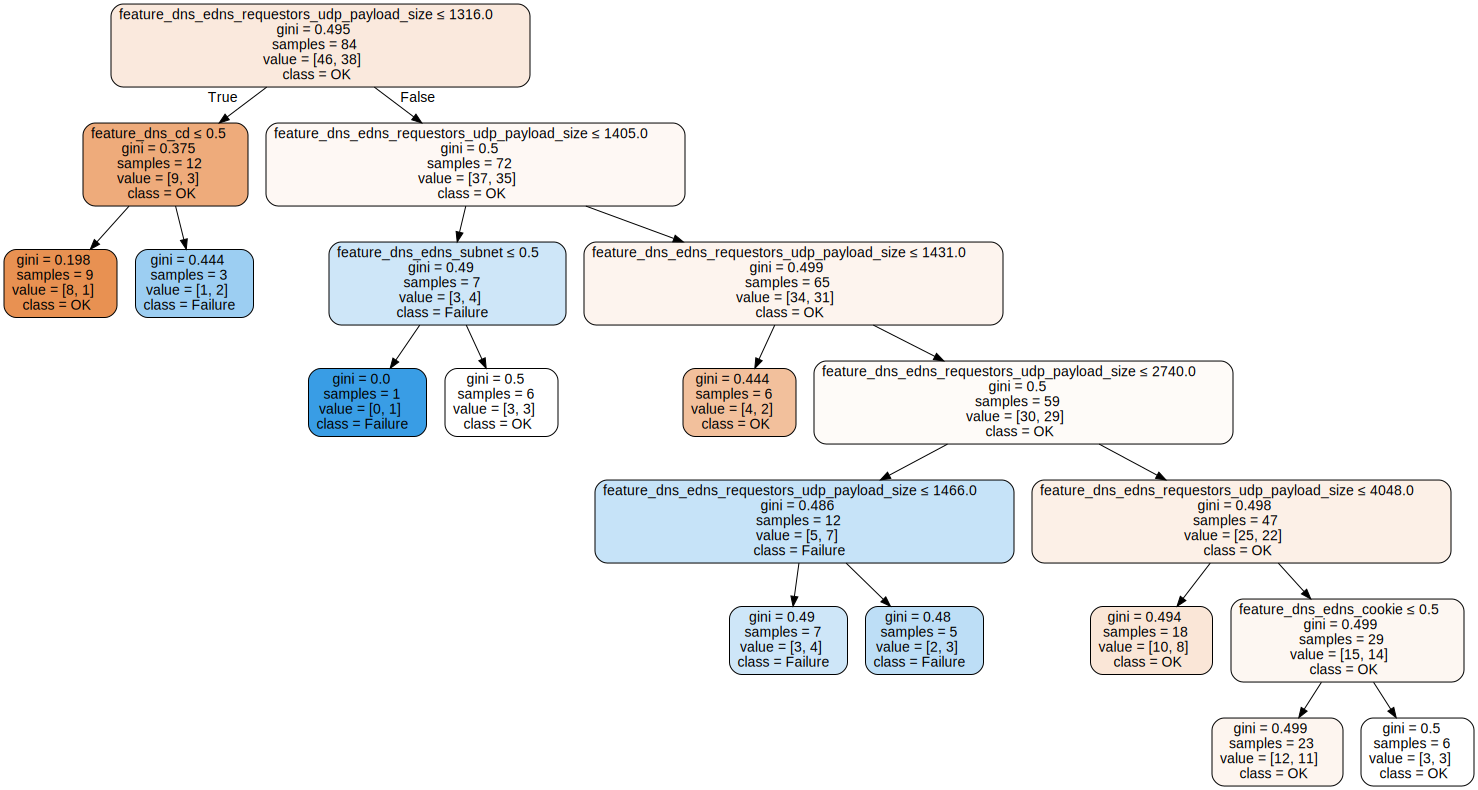

In [12]:
graphs['rsasha1']

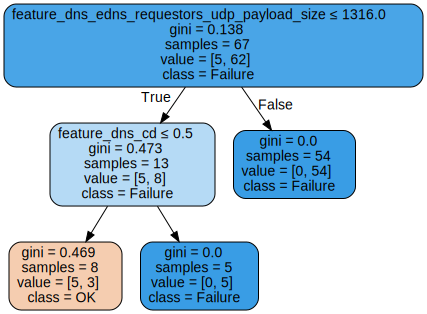

In [13]:
graphs['rsasha1nsec3sha1']

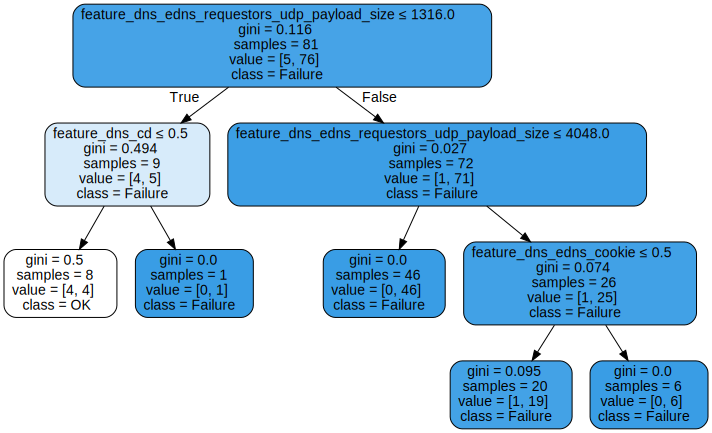

In [14]:
graphs['rsasha256']

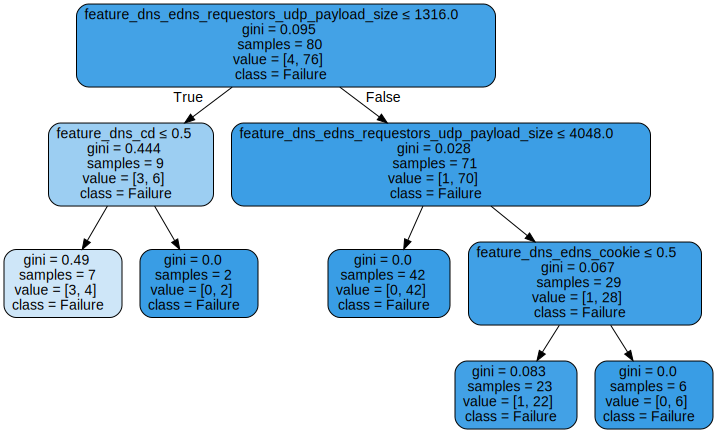

In [15]:
graphs['rsasha512']

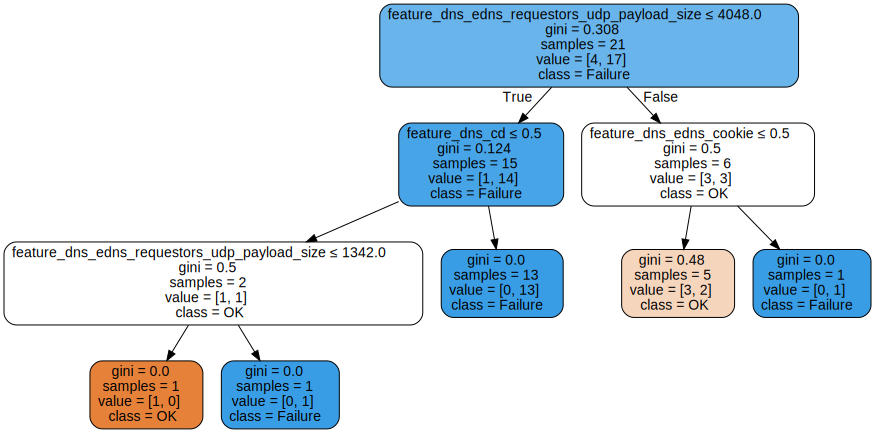

In [16]:
graphs['ecdsap256sha256']

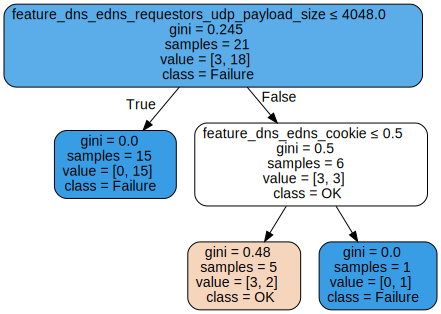

In [17]:
graphs['ecdsap384sha384']

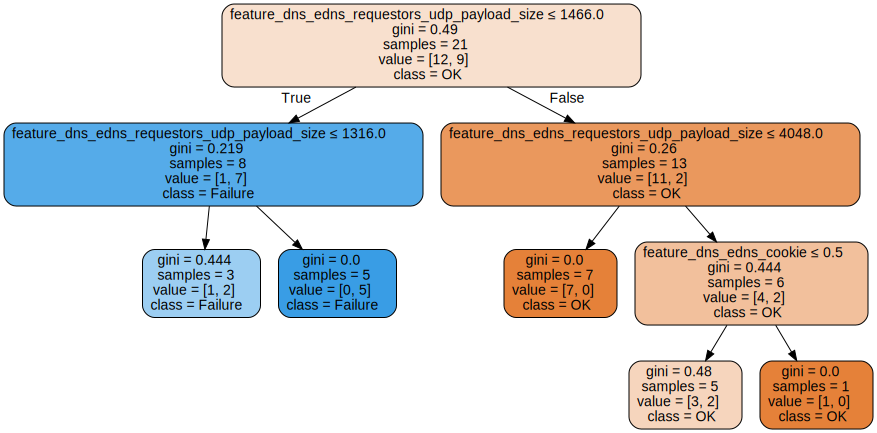

In [18]:
graphs['ed25519']

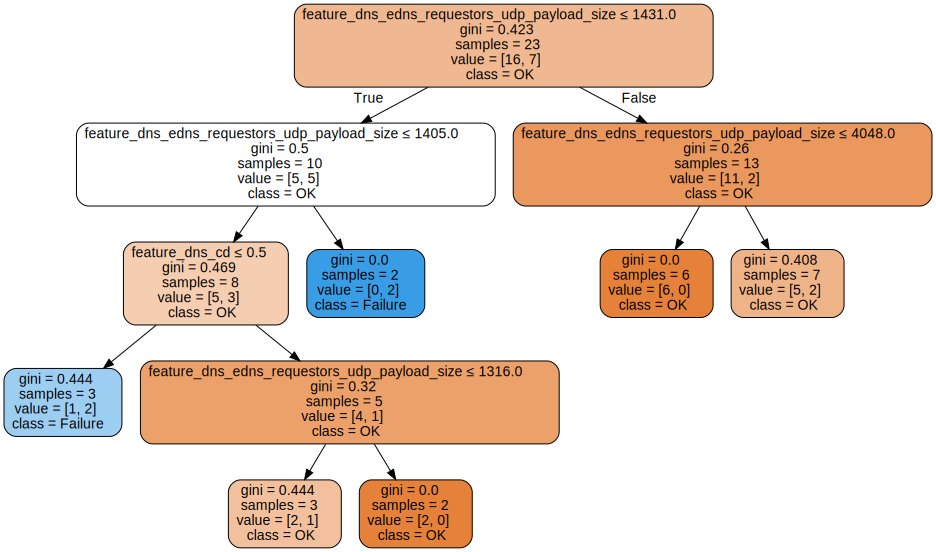

In [19]:
graphs['ed448']

# Predicting Cipher

In [20]:
# putting all data together
fdata = pd.concat([d for d in data.values()])

In [21]:
# predicting for each algorithm
X = fdata[features]
Y = fdata[label]

for algo, t in tree.items():
    fdata[f'pred_{algo}'] = t.predict(X)

In [135]:
# computing choice for each row
fdata['selected'] = 0
for algo in priority:
    fdata.loc[fdata[f'pred_{algo}'], 'selected'] = algo

In [116]:
fdata[['resolver', 'qname', 'selected']]

,resolver,qname,selected
26,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-10...,ed448
29,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-10...,ed448
32,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-18...,ed448
35,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-18...,ed448
38,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-20...,ed448
...,...,...,...
2344,ws2012,b'lab-ws2012-20210617024144.ed448-456-3-signed...,ecdsap384sha384
2463,ws2016,b'lab-ws2016-20210617024144.ed448-456-1-signed...,ecdsap384sha384
2466,ws2016,b'lab-ws2016-20210617024144.ed448-456-3-signed...,ecdsap384sha384
2585,ws2019,b'lab-ws2019-20210617024144.ed448-456-1-signed...,ecdsap384sha384


In [117]:
resolver_best = pd.read_pickle('resolver_best.pickle')[('zone_algorithm', 'best_algo')].to_dict()
resolver_best

{'bind9113': 'ecdsap384sha384',
 'powerdns460': 'ed448',
 'unbound167': 'ed25519',
 'ws2012': 'ecdsap384sha384',
 'ws2012r2': 'ecdsap384sha384',
 'ws2016': 'ecdsap384sha384',
 'ws2019': 'ecdsap384sha384',
 'cisco': 'ed448',
 'cloudflare': 'ed25519',
 'comodo': 'ed448',
 'cznic': 'ed25519',
 'google': 'ed25519',
 'kresd532': 'ecdsap384sha384',
 'neustar': 'rsasha512',
 'norton': 'rsasha512',
 'oracle': 'ecdsap384sha384'}

In [118]:
resolvers = set(resolver_best.keys() | {'freenom', 'opennic', 'quad9'})
resolvers_lab = {'bind9113',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_named_open = resolvers - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named_open))
resolver_order

['bind9113',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019',
 'cisco',
 'cloudflare',
 'comodo',
 'cznic',
 'freenom',
 'google',
 'kresd532',
 'neustar',
 'norton',
 'opennic',
 'oracle',
 'quad9']

In [119]:
fdata['best supported'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], None), axis=1)
fdata['pred_num'] = fdata.apply(lambda row: ALGO_NUM[row['pred']], axis=1)
fdata['best_algo_num'] = fdata.apply(lambda row: ALGO_NUM.get(row['best_algo'], None), axis=1)
fdata['correct'] = (fdata['pred'] == fdata['best_algo']).astype(np.float)
fdata['overestimated'] = (fdata['pred_num'] > fdata['best_algo_num']).astype(np.float)
fdata['underestimated'] = (fdata['pred_num'] < fdata['best_algo_num']).astype(np.float)
fdata['better than recommended'] = (fdata['pred_num'] > 13).astype(np.float)

In [120]:
fdata[['resolver', 'qname', 'selected', 'best supported', 'correct', 'overestimated', 'underestimated']]

,resolver,qname,selected,best supported,correct,overestimated,underestimated
26,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-10...,ed448,ed448,1.0,0.0,0.0
29,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-10...,ed448,ed448,1.0,0.0,0.0
32,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-18...,ed448,ed448,1.0,0.0,0.0
35,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-18...,ed448,ed448,1.0,0.0,0.0
38,cisco,b'opn-cisco-umbrella-20210617014323.rsasha1-20...,ed448,ed448,1.0,0.0,0.0
...,...,...,...,...,...,...,...
2344,ws2012,b'lab-ws2012-20210617024144.ed448-456-3-signed...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
2463,ws2016,b'lab-ws2016-20210617024144.ed448-456-1-signed...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
2466,ws2016,b'lab-ws2016-20210617024144.ed448-456-3-signed...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
2585,ws2019,b'lab-ws2019-20210617024144.ed448-456-1-signed...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0


In [130]:
def list_values(c):
    return set(c)

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    raise ValueError()

cipher_selection = fdata[~fdata['best_algo'].isna()].groupby(['resolver']).agg({
    'selected': [single_value],
    'best supported': [single_value],
    'correct': ['mean'],
    'underestimated': ['mean'],
    'overestimated': ['mean'],
    'better than recommended': ['mean'],
}).sort_values('resolver', key=lambda r: list(map(lambda e: resolver_order.index(e), r)))
cipher_selection.columns = cipher_selection.columns.droplevel(1)
cipher_selection = cipher_selection.reset_index()
print(cipher_selection.to_latex(
    float_format=lambda f: f"{f:.0%}",
    index=False,
))
cipher_selection

\begin{tabular}{lllrrrr}
\toprule
    resolver &         selected &   best supported &  correct &  underestimated &  overestimated &  better than recommended \\
\midrule
    bind9113 &  ecdsap384sha384 &  ecdsap384sha384 &     100\% &              0\% &             0\% &                     100\% \\
 powerdns460 &            ed448 &            ed448 &     100\% &              0\% &             0\% &                     100\% \\
  unbound167 &        rsasha512 &          ed25519 &       0\% &            100\% &             0\% &                       0\% \\
      ws2012 &  ecdsap384sha384 &  ecdsap384sha384 &     100\% &              0\% &             0\% &                     100\% \\
    ws2012r2 &  ecdsap384sha384 &  ecdsap384sha384 &     100\% &              0\% &             0\% &                     100\% \\
      ws2016 &  ecdsap384sha384 &  ecdsap384sha384 &     100\% &              0\% &             0\% &                     100\% \\
      ws2019 &  ecdsap384sha384 &  ecdsap384

,resolver,selected,best supported,correct,underestimated,overestimated,better than recommended
0,bind9113,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
1,powerdns460,ed448,ed448,1.0,0.0,0.0,1.0
2,unbound167,rsasha512,ed25519,0.0,1.0,0.0,0.0
3,ws2012,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
4,ws2012r2,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
5,ws2016,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
6,ws2019,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
7,cisco,ed448,ed448,1.0,0.0,0.0,1.0
8,cloudflare,ed25519,ed25519,1.0,0.0,0.0,1.0
9,comodo,rsasha512,ed448,0.0,1.0,0.0,0.0
